# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB)

In [61]:
# import libraries

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import desc, asc, udf, lit, countDistinct, sum, when, isnan

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [32]:
# create a Spark session
spark = SparkSession.builder.master('local').appName('Sparkify Churn Project').getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [33]:
sparkify_event_data = spark.read.json('./mini_sparkify_event_data.json')
sparkify_event_data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# 2. Exploratory Data Analysis

In [4]:
sparkify_event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
sparkify_event_data.count(), len(sparkify_event_data.columns)

(286500, 18)

In [6]:
sparkify_event_data.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

### 2.1. Process Null Values

In [7]:
# Check null values
for col in sparkify_event_data.schema.names: 
    print(col, sparkify_event_data.filter((sparkify_event_data[col] == "") | sparkify_event_data[col].isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 8346


There are two count numbers of missing values - 8346 and 58392.

In [8]:
for col in ['gender', 'level']:
    sparkify_event_data.groupby(col).agg(countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|  null|                     1|
|     M|                   121|
+------+----------------------+

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   196|
| paid|                   166|
+-----+----------------------+



In [9]:
for col in ['auth','method', 'page']:
    sparkify_event_data.groupby(col).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 ro

In [34]:
# drop null values in column 'gender'. 
sparkify_event_data = sparkify_event_data.filter(sparkify_event_data.gender.isNotNull())

In [11]:
for col in ['gender', 'level']:
    sparkify_event_data.groupby(col).agg(countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   195|
| paid|                   165|
+-----+----------------------+



In [12]:
for col in ['auth','method', 'page']:
    print(sparkify_event_data.groupby(col).count().show(100))

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

None
+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+

None
+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+

None


Dropped null records in column gender are logged-out visitors and guests. In total of 8346 rows. The rest 50046 null values are within the columns 'artist', 'length' and 'song'. 

In [13]:
for col in sparkify_event_data.schema.names: 
    print(col, sparkify_event_data.filter((sparkify_event_data[col] == "") | sparkify_event_data[col].isNull()).count())

artist 50046
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 50046
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 50046
status 0
ts 0
userAgent 0
userId 0


In [14]:
for col in ['artist','length','song']:
    sparkify_event_data.filter((sparkify_event_data[col] != "") | sparkify_event_data[col].isNotNull()).select('page').distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+

+--------+
|    page|
+--------+
|NextSong|
+--------+

+--------+
|    page|
+--------+
|NextSong|
+--------+



'artist','length' and 'song' are non-null only for pages 'NextSong'.

In [35]:
# convert timestamp to date and time
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x /1000.0).strftime('%Y-%m-%d %H:%M:%S'))
sparkify_event_data = sparkify_event_data.withColumn("datetime", get_datetime(sparkify_event_data.ts))
sparkify_event_data.select('datetime').describe().show()

+-------+-------------------+
|summary|           datetime|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



### 2.2. Define Churn
Define based whether a user visited page 'Cancellation Confirmation'.

In [36]:
# Create var 'Churn'
churn_users = sparkify_event_data.select('userId').where(sparkify_event_data.page == 'Cancellation Confirmation').distinct().\
                    withColumn('is_churn', lit(1))
sparkify_event_churn = sparkify_event_data.join(churn_users, on = 'userId', how = 'left')
sparkify_event_churn = sparkify_event_churn.fillna({'is_churn':0})
sparkify_event_churn.groupby('is_churn').agg(countDistinct('userId')).show()

+--------+----------------------+
|is_churn|count(DISTINCT userId)|
+--------+----------------------+
|       1|                    52|
|       0|                   173|
+--------+----------------------+



### 2.3. Explore Dataset with Churn

In [37]:
# generate full userId list with gender
user_gender = sparkify_event_churn.select('userId','gender').distinct()

# was or is paid user
paid_users = sparkify_event_churn.select('userId').where(sparkify_event_churn.level == 'paid').distinct().\
                    withColumn('is_paid_user', lit(1))

In [38]:
# calculte num of songs, num of artist listened to, number of sessions, number of pages visited per user
num_of_events = {} 
for col in ['artist','page','sessionId','song']:  
        num_of_events[col] = sparkify_event_churn.groupby('userId').agg(countDistinct(col))
                

In [39]:
# count num of spefific pagesviews per user
page_cnts = spark.createDataFrame(sparkify_event_churn.groupby('userId', 'page').count().toPandas().\
                        pivot(index = 'userId', columns = 'page', values = 'count').reset_index().\
                                 rename(columns = {'Add Friend':'Add_Friend', 'Roll Advert':'Roll_Advert', 'Thumbs Down':'Thumbs_Down',\
                                                    'Thumbs Up':'Thumbs_Up'}))
page_cnts = page_cnts.select('userId','Add_Friend', 'Downgrade', 'Upgrade', 'Error', 'Help', 'Logout', 'NextSong', \
                             'Roll_Advert', 'Thumbs_Down', 'Thumbs_Up')

In [40]:
# Add most frequent device
get_device = udf(lambda x: x.split('(')[1].split(';')[0].split(' ')[0])
sparkify_event_churn = sparkify_event_churn.withColumn("device", get_device(sparkify_event_churn.userAgent))
device_cnts = sparkify_event_churn.groupby('userId', 'device').count().toPandas()
device_cnts = spark.createDataFrame(device_cnts.sort_values(['userId','count']).\
                                    drop_duplicates(subset = 'userId', keep = 'last'))

In [41]:
# merge dataset
data = user_gender.\
        join(churn_users, on = 'userId', how = 'left').\
        join(paid_users, on = 'userId', how = 'left').\
        join(page_cnts, on = 'userId', how = 'left').\
        join(device_cnts, on = 'userId', how = 'left')
for v in num_of_events.values():
        data = data.join(v, on = 'userId', how = 'left')
data = data.withColumnRenamed('count(DISTINCT artist)', 'num_artists') \
            .withColumnRenamed('count(DISTINCT page)', 'num_pages') \
            .withColumnRenamed('count(DISTINCT sessionId)', 'num_sessions') \
            .withColumnRenamed('count(DISTINCT song)', 'num_songs')
data = data.fillna(0)
data = data.drop('count')

In [61]:
data.limit(5).toPandas()

,userId,gender,is_churn,is_paid_user,Add_Friend,Downgrade,Upgrade,Error,Help,Logout,NextSong,Roll_Advert,Thumbs_Down,Thumbs_Up,device,num_artists,num_pages,num_sessions,num_songs
0,100010,F,0,0,4.0,0.0,2.0,0.0,2.0,5.0,275.0,52.0,5.0,17.0,iPhone,252,11,7,269
1,200002,M,0,1,4.0,5.0,2.0,0.0,2.0,5.0,387.0,7.0,6.0,21.0,iPhone,339,14,6,378
2,125,M,1,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,Macintosh,8,4,1,8
3,124,F,0,1,74.0,41.0,0.0,6.0,23.0,59.0,4079.0,4.0,41.0,171.0,Macintosh,2232,14,29,3339
4,51,M,1,1,28.0,23.0,0.0,1.0,12.0,24.0,2111.0,0.0,21.0,100.0,Windows,1385,15,10,1854


In [62]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- is_churn: integer (nullable = true)
 |-- is_paid_user: integer (nullable = true)
 |-- Add_Friend: double (nullable = false)
 |-- Downgrade: double (nullable = false)
 |-- Upgrade: double (nullable = false)
 |-- Error: double (nullable = false)
 |-- Help: double (nullable = false)
 |-- Logout: double (nullable = false)
 |-- NextSong: double (nullable = false)
 |-- Roll_Advert: double (nullable = false)
 |-- Thumbs_Down: double (nullable = false)
 |-- Thumbs_Up: double (nullable = false)
 |-- device: string (nullable = true)
 |-- num_artists: long (nullable = true)
 |-- num_pages: long (nullable = true)
 |-- num_sessions: long (nullable = true)
 |-- num_songs: long (nullable = true)



In [63]:
data.count(), len(data.columns)

(225, 19)

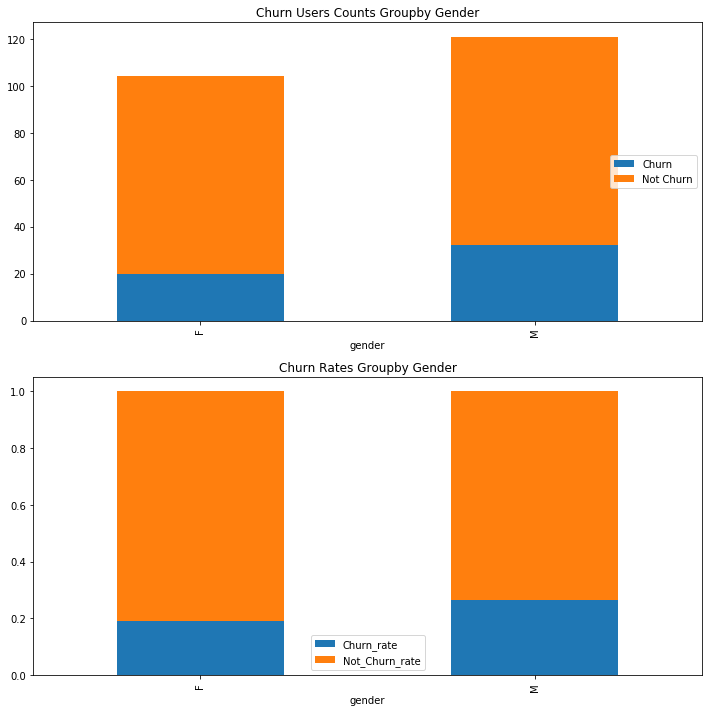

In [84]:
# Churn rates by Gender
churn_by_gender = data.groupby('gender', 'is_churn').agg(countDistinct('userId')).toPandas().rename(columns = {'count(DISTINCT userId)':'num_of_users'})\
       .pivot(index = 'gender', columns = 'is_churn', values = 'num_of_users').\
           rename(columns = {0:'Not Churn', 1:'Churn'})

churn_by_gender['All']= churn_by_gender['Not Churn'] + churn_by_gender['Churn']
churn_by_gender['Churn_rate'] = churn_by_gender['Churn'] / churn_by_gender['All']
churn_by_gender['Not_Churn_rate'] = 1 - churn_by_gender['Churn_rate']

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(2,1,1)
churn_by_gender[['Churn','Not Churn']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Users Counts Groupby Gender')
plt.legend(loc = 'right')
ax2 = fig.add_subplot(2,1,2)
churn_by_gender[['Churn_rate','Not_Churn_rate']].plot(kind = 'bar', ax = ax2, stacked = True)
plt.title('Churn Rates Groupby Gender')
plt.legend(loc = 'best')
plt.tight_layout()

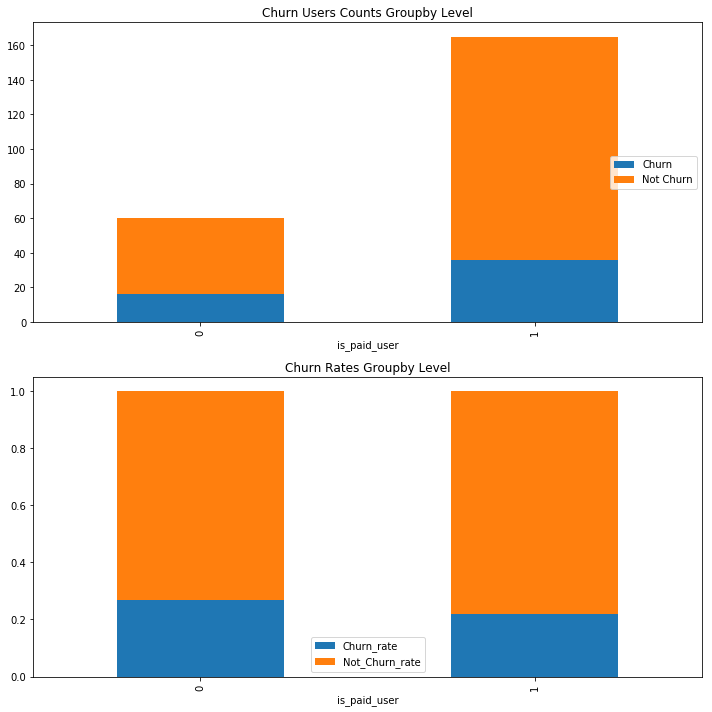

In [83]:
# Churn rates by paid level
churn_by_level = data.groupby('is_paid_user', 'is_churn').agg(countDistinct('userId')).toPandas()\
    .rename(columns = {'count(DISTINCT userId)':'num_of_users'}).pivot(index = 'is_paid_user', \
                        columns = 'is_churn', values = 'num_of_users').rename(columns = {0:'Not Churn', 1:'Churn'})

churn_by_level['All']= churn_by_level['Not Churn'] + churn_by_level['Churn']
churn_by_level['Churn_rate'] = churn_by_level['Churn'] / churn_by_level['All']
churn_by_level['Not_Churn_rate'] = 1 - churn_by_level['Churn_rate']

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(2,1,1)
churn_by_level[['Churn','Not Churn']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Users Counts Groupby Level')
plt.legend(loc = 'right')
ax2 = fig.add_subplot(2,1,2)
churn_by_level[['Churn_rate','Not_Churn_rate']].plot(kind = 'bar', ax = ax2, stacked = True)
plt.title('Churn Rates Groupby Level')
plt.legend(loc = 'best')
plt.tight_layout()

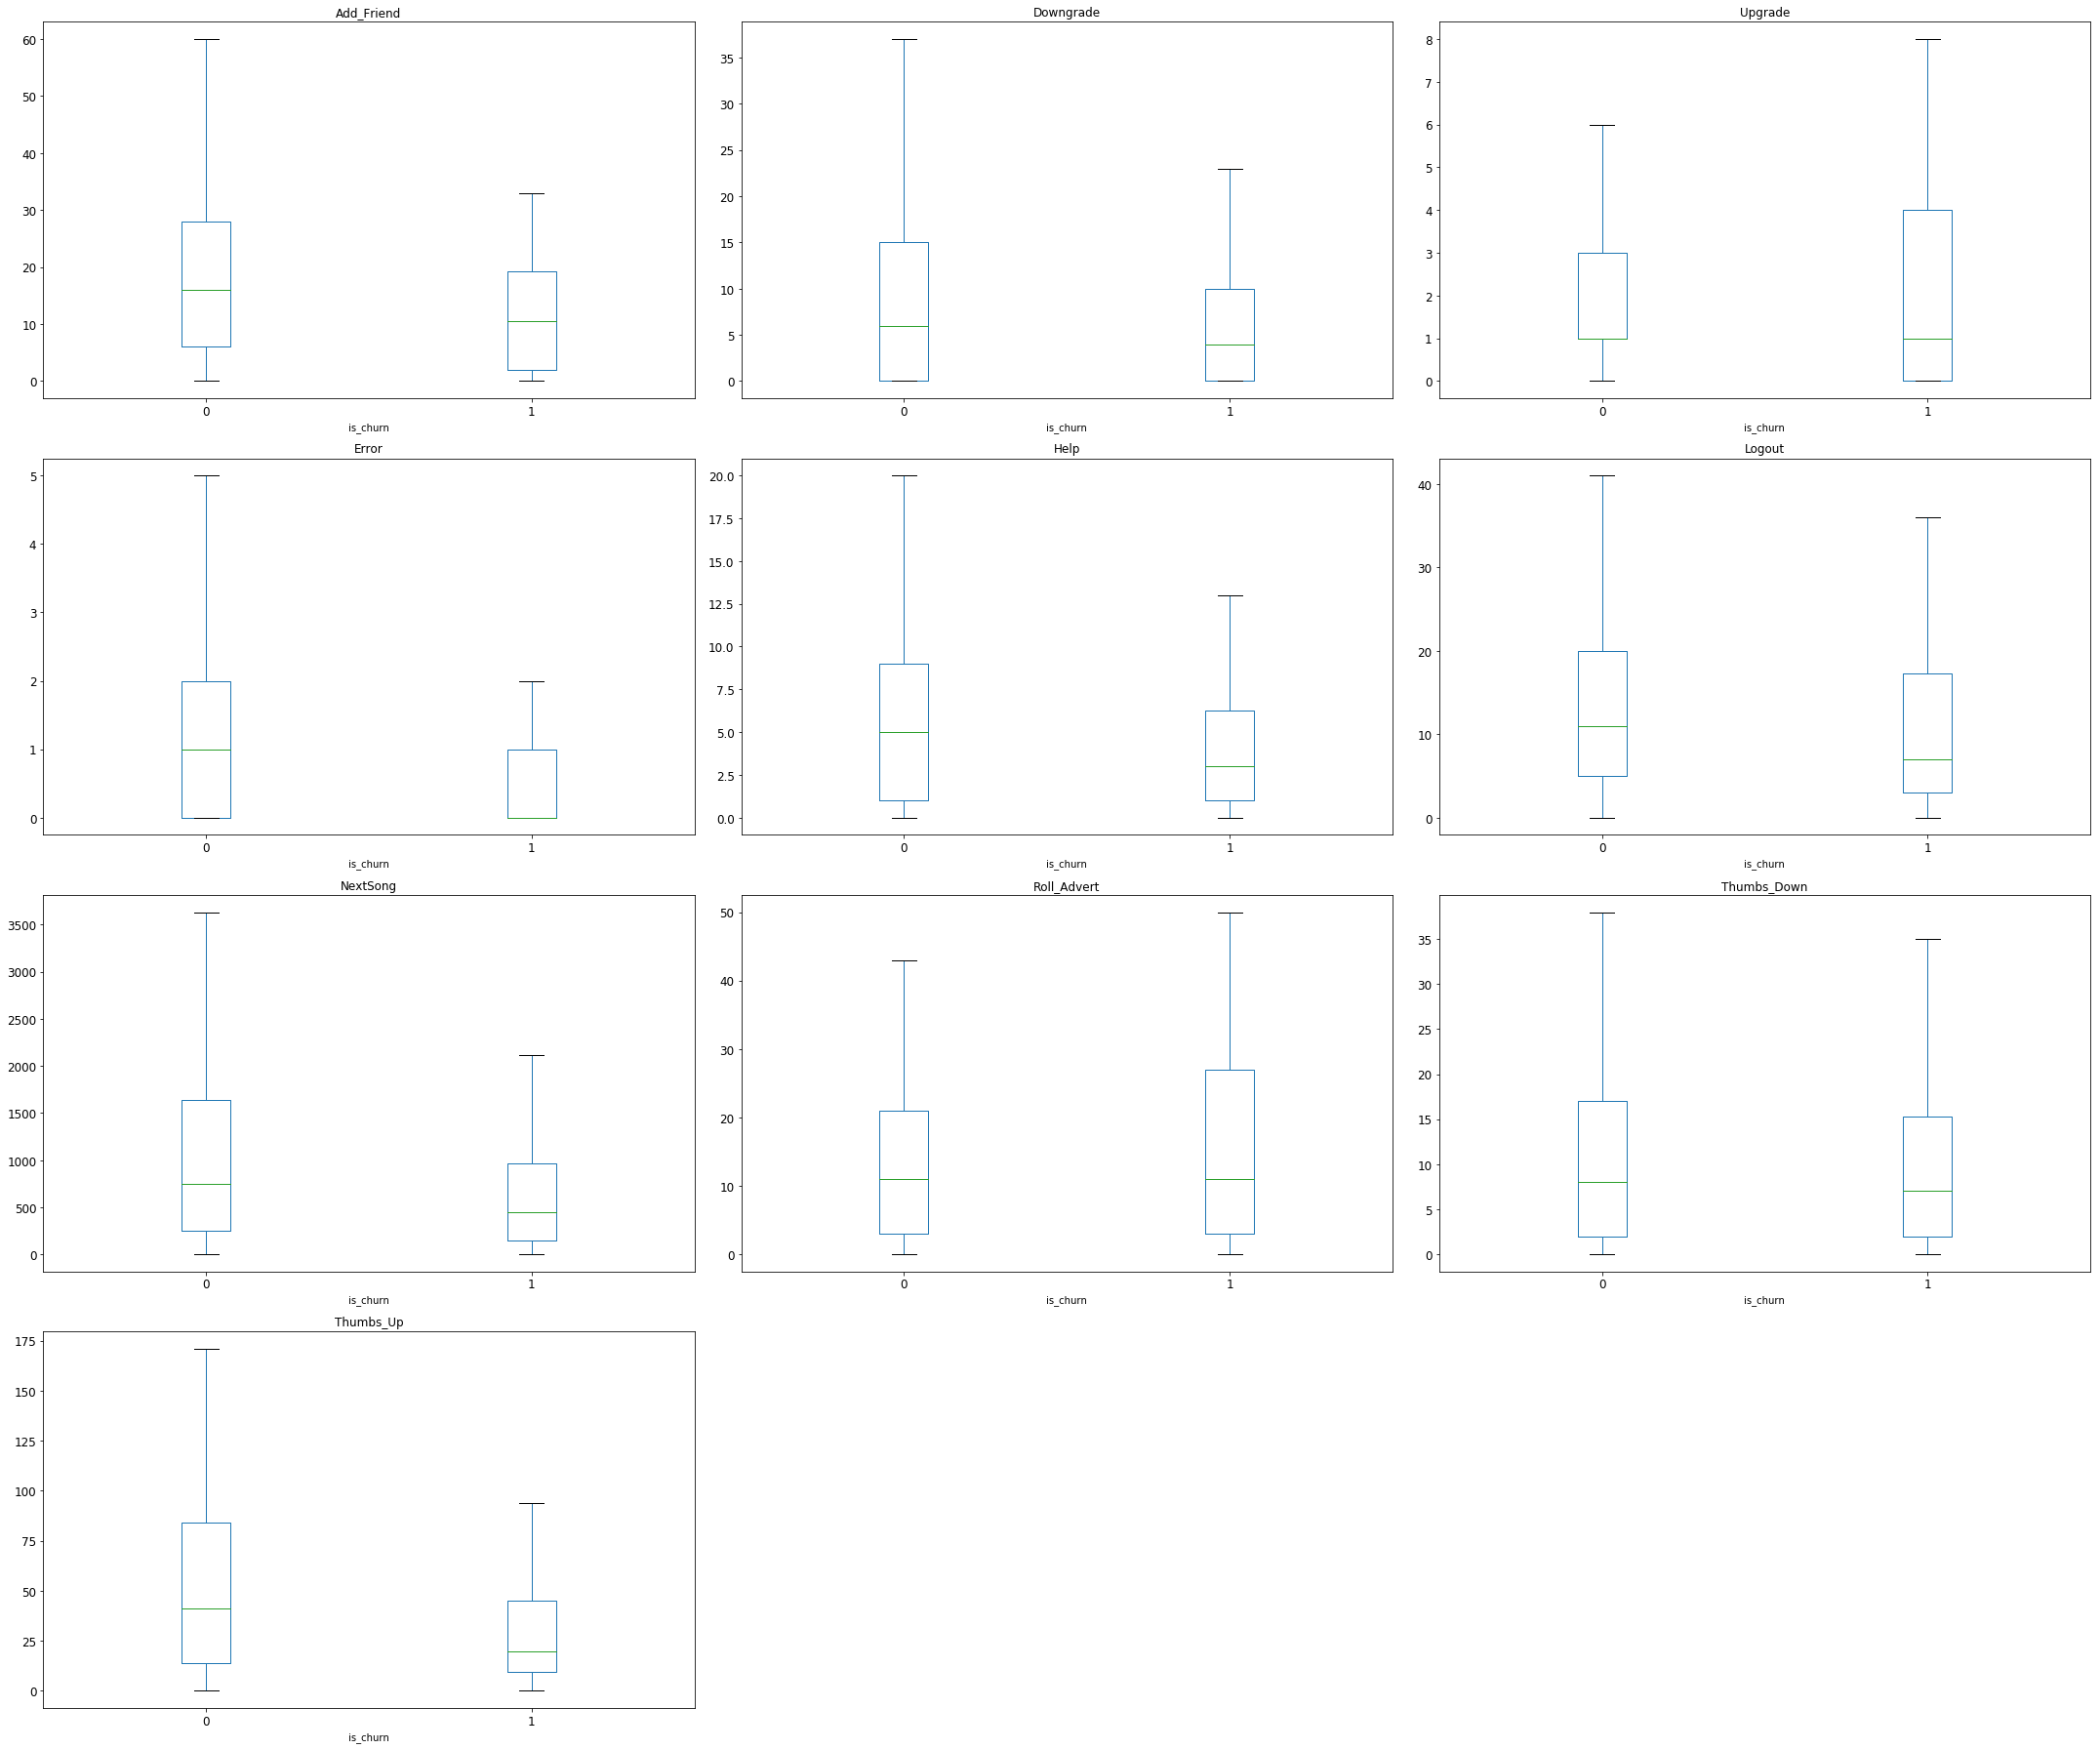

In [14]:
# events vs churn
event_categories = ['Add_Friend','Downgrade','Upgrade','Error','Help',\
                    'Logout','NextSong','Roll_Advert','Thumbs_Down','Thumbs_Up']
data_df = data.toPandas()
fig = plt.figure(figsize = (30, 25))
for i, col in enumerate(event_categories):
    ax = fig.add_subplot(4,3,i+1)
    data_df.boxplot(col, ax = ax, grid = False, by = 'is_churn', fontsize = 'large', showfliers=False)
fig.suptitle('')
plt.tight_layout()
plt.show()

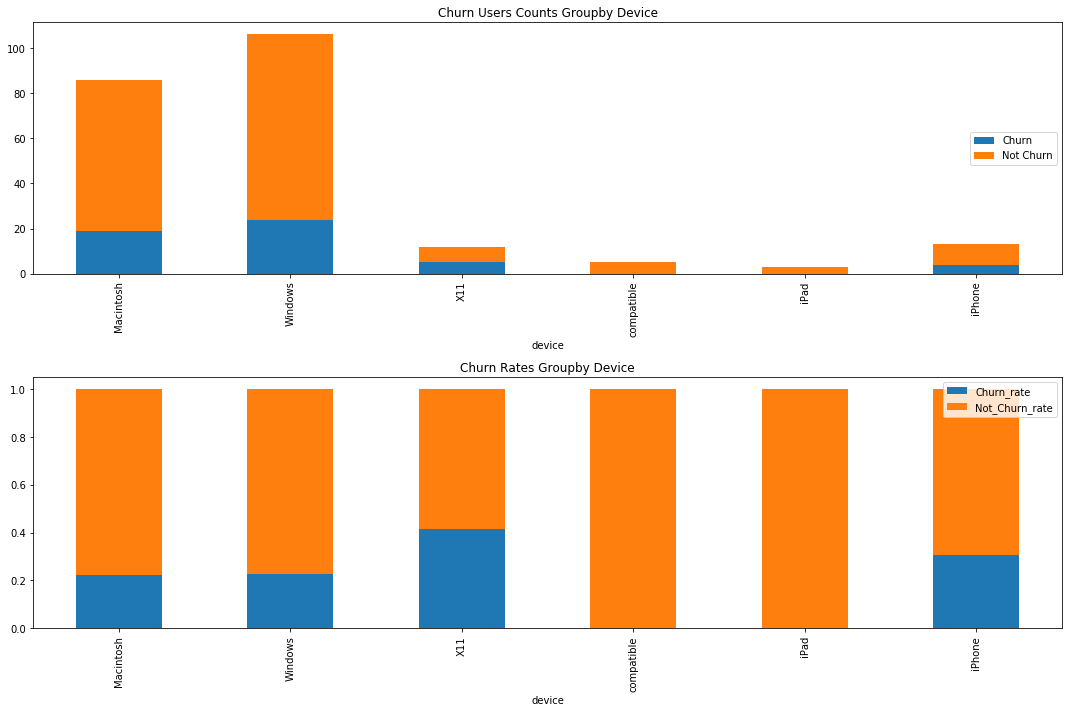

In [85]:
churn_by_device = data.groupby('device', 'is_churn').agg(countDistinct('userId')).toPandas()\
    .rename(columns = {'count(DISTINCT userId)':'num_of_users'}).pivot(index = 'device', \
                        columns = 'is_churn', values = 'num_of_users').rename(columns = {0:'Not Churn', 1:'Churn'})
churn_by_device.fillna(0, inplace = True)
churn_by_device['All']= churn_by_device['Not Churn'] + churn_by_device['Churn']
churn_by_device['Churn_rate'] = churn_by_device['Churn'] / churn_by_device['All']
churn_by_device['Not_Churn_rate'] = 1 - churn_by_device['Churn_rate']

fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2,1,1)
churn_by_device[['Churn','Not Churn']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Users Counts Groupby Device')
plt.legend(loc = 'right')
ax2 = fig.add_subplot(2,1,2)
churn_by_device[['Churn_rate','Not_Churn_rate']].plot(kind = 'bar', ax = ax2, stacked = True)
plt.title('Churn Rates Groupby Device')
plt.legend(loc = 'best')
plt.tight_layout()

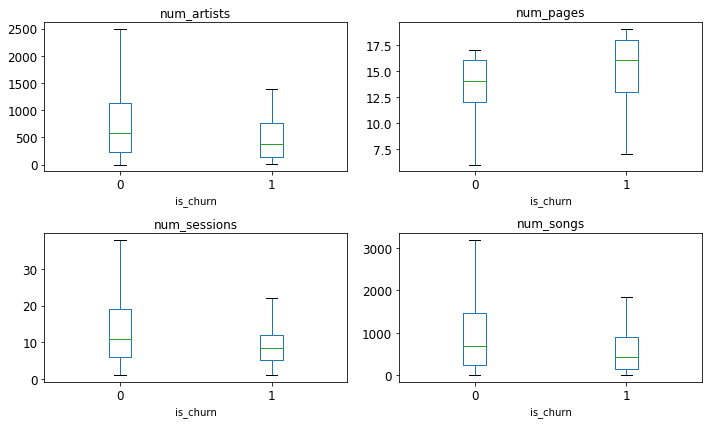

In [37]:
# Churn vs music-related metric
music_events = ['num_artists','num_pages','num_sessions','num_songs']  
data_df = data.toPandas()
fig = plt.figure(figsize = (10, 6))
for i, col in enumerate(music_events):
    ax = fig.add_subplot(2,2,i+1)
    data_df.boxplot(col, ax = ax, grid = False, by = 'is_churn', fontsize = 'large', showfliers=False)
fig.suptitle('')
plt.tight_layout()
plt.show()

# 3. Feature Engineering

Features are generated on user level. 
- gender (Male: 1; Female: 0)
- level (paid or free)
- most frequent device
- number of songs listened per user
- number of artists listened to per user
- number of sessions per user
- avg number of pages visited per session per user
- number of ads views per user
- number of pageviews of 'Error' per user
- number of pageviews of 'Help' per user
- number of pageviews of 'Downgrade' per user
- number of pageviews of 'Upgrade' per user
- number of pageviews of 'Logout' per user
- percentage of thumb-ups of total 'NextSong' pagesviews per user
- percentage of thumb-downs of total 'NextSong' pagesviews per user

In [42]:
data = data.withColumn('gender', when(data.gender == 'M', 1).otherwise(0))

In [43]:
data = data.withColumn('pages_per_session', (data.num_pages/data.num_sessions).cast(FloatType()))

In [44]:
data = data.withColumn('thumbups_ratio', (data.Thumbs_Up/data.NextSong).cast(FloatType()))

In [45]:
data = data.withColumn('thumbdowns_ratio', (data.Thumbs_Down/data.NextSong).cast(FloatType()))

In [46]:
device = data.groupby('userId').pivot('device').agg(lit(1)).fillna(0)
data = data.join(device, on = 'userId', how = 'left')

In [47]:
data = data.drop('device')
data = data.withColumn('label', data['is_churn'].cast('float')).drop('is_churn')

In [48]:
feature_col = data.drop('userId', 'label').columns
feature_col

['gender',
 'is_paid_user',
 'Add_Friend',
 'Downgrade',
 'Upgrade',
 'Error',
 'Help',
 'Logout',
 'NextSong',
 'Roll_Advert',
 'Thumbs_Down',
 'Thumbs_Up',
 'num_artists',
 'num_pages',
 'num_sessions',
 'num_songs',
 'pages_per_session',
 'thumbups_ratio',
 'thumbdowns_ratio',
 'Macintosh',
 'Windows',
 'X11',
 'compatible',
 'iPad',
 'iPhone']

In [25]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- is_paid_user: integer (nullable = true)
 |-- Add_Friend: double (nullable = false)
 |-- Downgrade: double (nullable = false)
 |-- Upgrade: double (nullable = false)
 |-- Error: double (nullable = false)
 |-- Help: double (nullable = false)
 |-- Logout: double (nullable = false)
 |-- NextSong: double (nullable = false)
 |-- Roll_Advert: double (nullable = false)
 |-- Thumbs_Down: double (nullable = false)
 |-- Thumbs_Up: double (nullable = false)
 |-- num_artists: long (nullable = true)
 |-- num_pages: long (nullable = true)
 |-- num_sessions: long (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- pages_per_session: float (nullable = true)
 |-- thumbups_ratio: float (nullable = true)
 |-- thumbdowns_ratio: float (nullable = true)
 |-- Macintosh: integer (nullable = true)
 |-- Windows: integer (nullable = true)
 |-- X11: integer (nullable = true)
 |-- compatible: integer (nullable = true)


In [113]:
# Check null values
for col in data.schema.names: 
    print(col, data.filter((data[col] == "") | data[col].isNull()).count())

userId 0
gender 0
is_churn 0
is_paid_user 0
Add_Friend 0
Downgrade 0
Upgrade 0
Error 0
Help 0
Logout 0
NextSong 0
Roll_Advert 0
Thumbs_Down 0
Thumbs_Up 0
num_artists 0
num_pages 0
num_sessions 0
num_songs 0
pages_per_session 0
thumbups_ratio 0
thumbdowns_ratio 0
Macintosh 0
Windows 0
X11 0
compatible 0
iPad 0
iPhone 0


In [19]:
data.limit(3).toPandas()

,userId,gender,is_churn,is_paid_user,Add_Friend,Downgrade,Upgrade,Error,Help,Logout,...,num_songs,pages_per_session,thumbups_ratio,thumbdowns_ratio,Macintosh,Windows,X11,compatible,iPad,iPhone
0,100010,0,0,0,4.0,0.0,2.0,0.0,2.0,5.0,...,269,1.571429,0.061818,0.018182,0,0,0,0,0,1
1,200002,1,0,1,4.0,5.0,2.0,0.0,2.0,5.0,...,378,2.333333,0.054264,0.015504,0,0,0,0,0,1
2,125,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,4.000000,0.000000,0.000000,1,0,0,0,0,0


# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 4.1 Train Test Split

In [49]:
train, test = data.drop('userId').randomSplit([0.8, 0.2], seed = 42)

### 4.2 Build Pipeline

In [59]:
def buildPipeline(classifier):
    assembler = VectorAssembler(inputCols = feature_col, outputCol = 'VecFeatures')
    scaler = StandardScaler(inputCol="VecFeatures", outputCol="ScaledVecFeatures", withStd=True)
    #lr = LogisticRegression(labelCol="label", featuresCol="ScaledVecFeatures")
    pipeline = Pipeline(stages = [assembler, scaler, classifer])
    start = time.time()
    model = pipeline.fit(train)
    train_time = time.time() - start
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1score_train = evaluator.evaluate(pred_train)
    f1score_test = evaluator.evaluate(pred_test)
    res = {}
    res['f1train'] = f1score_train
    res['f1test'] = f1score_test
    res['time'] = train_time
    return res

In [60]:
# Logistic Regression
classifer = LogisticRegression(labelCol="label", featuresCol="ScaledVecFeatures")
lr = buildPipeline(classifer)
print(lr)


{'f1train': 0.8447041533615376, 'f1test': 0.789197188309286, 'time': 501.80632519721985}


In [62]:
# Random Forest
classifer = RandomForestClassifier(labelCol="label", featuresCol="ScaledVecFeatures")
rf = buildPipeline(classifer)
print(rf)

{'f1train': 0.9027718270024856, 'f1test': 0.7797160243407708, 'time': 268.3415024280548}


In [63]:
# Gradient Boosted Tree
classifer = GBTClassifier(labelCol="label", featuresCol="ScaledVecFeatures")
gbt = buildPipeline(classifer)
print(gbt)

{'f1train': 1.0, 'f1test': 0.798154555940023, 'time': 647.369368314743}


In [50]:
# assembler = VectorAssembler(inputCols = feature_col, outputCol = 'VecFeatures')
# scaler = StandardScaler(inputCol="VecFeatures", outputCol="ScaledVecFeatures", withStd=True)
# lr = LogisticRegression(labelCol="label", featuresCol="ScaledVecFeatures")
# pipeline = Pipeline(stages = [assembler, scaler, lr])


In [51]:
# model = pipeline.fit(train)
# pred_train = model.transform(train)
# pred_test = model.transform(test)

In [52]:
# evaluator = MulticlassClassificationEvaluator(metricName='f1')
# f1score_train = evaluator.evaluate(pred_train)
# f1score_test = evaluator.evaluate(pred_test)

In [53]:
# f1score_train

0.8447041533615376

In [54]:
# f1score_test

0.789197188309286